In [30]:
from proquest_text_parser import text2dict, main_parser_proquest, FactivaRtfParser
import spacy
from pickMFU import MFU_picker
from collections import defaultdict
import jsonpickle
import pandas as pd

### Parse text files
#### Variables moving forward:
1. `all_dict`
#### Findings:
1. All WA articles from Factiva are found to be overlapped with articles in ProQuest.
2. Yes and No searches also highly overlapped with the Voice search.

In [12]:
dir = "./data/raw_240227/voice"
file_num = 11
date = "2024-02-28"
voice_raw_list = main_parser_proquest(dir, file_num, date)
voice_dict = text2dict(voice_raw_list)

dir = "./data/raw_240227/yes"
file_num = 3
date = "2024-02-27"
yes_raw_list = main_parser_proquest(dir, file_num, date)
yes_dict = text2dict(yes_raw_list)

dir = "./data/raw_240227/no"
file_num = 2
date = "2024-02-27"
no_raw_list = main_parser_proquest(dir, file_num, date)
no_dict = text2dict(no_raw_list)

dir = './data/raw_240322/Factiva-20240322-1210.rtf'
rft_parser = FactivaRtfParser()
wa_dict = rft_parser.parse(dir)

print(f"Voice article numbers: {len(voice_dict)}")
print(f"Yes article numbers: {len(yes_dict)}")
print(f"No article numbers: {len(no_dict)}")
print(f"WA article numbers: {len(wa_dict)}")

Voice article numbers: 2137
Yes article numbers: 490
No article numbers: 410
WA article numbers: 76


In [18]:
all_dict = dict()
dict_list = [voice_dict, yes_dict, no_dict, wa_dict]
WA_overlap_count = 0
for i in range(len(dict_list)):
    dic = dict_list[i]
    for k, v in dic.items():
        all_dict[k] = v
        if k in all_dict:
            if i == 3:
                WA_overlap_count += 1
            # print(v)
            # print('\n')
            # print(all_dict[k])
            # print('\n')
            
print("WA_overlap_count:", WA_overlap_count)
print("Total article count:", len(all_dict))

# The assertion below shows that there are a lot of overlapped articles across search.
# assert len(all_dict) == sum([len(dic) for dic in dict_list]), print(len(all_dict), sum([len(dic) for dic in dict_list]))

WA_overlap_count: 76
Total article count: 2564


### Locate MF words with MFD2.
#### Variables moving forward:
1. `all_dict`
2. `key_list`
3. `mf_set`

In [ ]:
mf_set = ['care.virtue', 'care.vice', 'fairness.virtue', 'fairness.vice', 'loyalty.virtue', 'loyalty.vice', 'authority.virtue', 'authority.vice', 'sanctity.virtue', 'sanctity.vice',]
key_list = [key for key in all_dict.keys()]

In [23]:
""" MF counts based on MFD2 normalised by article length (token number).
- Use MFU_picker to locate MF words.
- Use SpaCy to remove stopwords and non alphabets when computing article length.
- Compute MF frequency normalised by article length for each article.
"""
nlp = spacy.load('en_core_web_sm')
mfu_picker = MFU_picker()
save_dir = "./data"

for key in key_list:
    raw_text = all_dict[key]['text']
    doc = nlp(raw_text)
    article_length = len([token for token in doc if token.is_alpha and not token.is_stop])
    mf_loc_info = mfu_picker.pickMFU(raw_text, mfd_ver='mfd2')
    
    # Store results
    all_dict[key]['mf_loc_info'] = mf_loc_info
    all_dict[key]['text_length'] = article_length

with open(save_dir+'all_dict.pickle', 'w') as f:
    f.write(jsonpickle.encode(all_dict))

In [29]:
# with open(save_dir+'all_dict.pickle', 'r') as f:
#     all_dict = jsonpickle.decode(f.read())

for k, v in all_dict.items():
    mf_counts = defaultdict(int)
    mf_nested_info = v['mf_loc_info'][3]

    # Record counts
    for item in mf_nested_info:
        for mf in item:
            mf_counts[mf['foundation']] += 1

    # Fill in absence mf counts with 0
    for mf in mf_set:
        if mf not in mf_counts:
            mf_counts[mf] = 0
    all_dict[k]['mfd2_counts'] = mf_counts
    all_dict[k]['mfd2_counts_norm'] = {mf: count/all_dict[k]['text_length'] for mf, count in mf_counts.items()}

with open(save_dir+'all_dict.pickle', 'w') as f:
    f.write(jsonpickle.encode(all_dict))

### Media based aggregation

#### Findings
1. Articles from Cairns post and News.com.au are not available.
2. Article length normalisation does not seem to work because it could impact moral signals more than the moral counts.

In [ ]:
{'7.30; Sydney',
 'ABC Premium News; Sydney',
 'Advocate; Burnie, Tas.',
 'Herald Sun; Melbourne, Vic.',
 'News.com.au; Sydney, N.S.W.',
 'Sun-Herald; Sydney, N.S.W.',
 'Sunday Age; Melbourne, Vic.',
 'Sydney Morning Herald; Sydney, N.S.W.',
 'The Advertiser; Adelaide, S. Aust.',
 'The Age; Melbourne, Vic.',
 'The Australian (Online); Canberra, A.C.T.',
 'The Cairns Post; Cairns, Qld.',
 'The Canberra Times; Canberra, A.C.T.',
 'The Courier - Mail; Brisbane, Qld.',
 'The Daily Telegraph (Online); Surrey Hills, N.S.W.',
 'The Examiner; Launceston, Tas.',
 'The Mercury (Online); Hobart Town',
 'The Northern Territory News; Darwin, N.T.',
 'The West Australian',
 'WAToday.com.au'}

# print([article_info['text'] for article_info in all_dict.values() if article_info['pub_title']=='The West Australian'][0])

<Axes: >

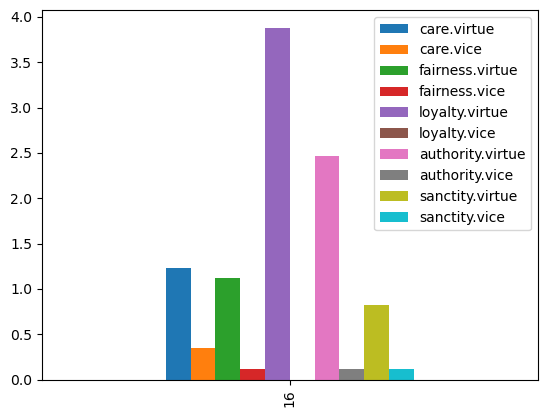

In [58]:
"""
Uncomment a code block for different visualisation.
"""

pre_df = {}
pre_df['media_column'] = [all_dict[key]['pub_title'] for key in key_list]
for mf in mf_set:
    pre_df[mf] = [all_dict[key]['mfd2_counts'][mf] for key in key_list]
df_media = pd.DataFrame(pre_df)

# For overview
# df_media.groupby('media_column').mean().plot.bar() 

# For a particular mf
# mf_target = ['care.virtue', 'care.vice']
# df_media.groupby('media_column').mean()[mf_target].plot.bar() 

# For a particular media
media_target = 'The Mercury (Online); Hobart Town'
df_mean = df_media.groupby('media_column').mean().reset_index()
df_mean[df_mean['media_column']==media_target].plot.bar() 

In [59]:
df_media

,media_column,care.virtue,care.vice,fairness.virtue,fairness.vice,loyalty.virtue,loyalty.vice,authority.virtue,authority.vice,sanctity.virtue,sanctity.vice
0,"The Australian (Online); Canberra, A.C.T.",2,0,2,1,2,0,8,1,1,0
1,7.30; Sydney,1,2,0,5,9,0,7,0,0,0
2,"The Australian (Online); Canberra, A.C.T.",0,2,0,1,3,0,1,0,1,0
3,"The Australian (Online); Canberra, A.C.T.",1,0,2,0,6,0,2,0,1,1
4,"The Australian (Online); Canberra, A.C.T.",1,2,4,3,4,0,3,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2559,The West Australian,1,0,2,0,5,0,1,0,0,0
2560,WAToday.com.au,3,0,4,0,9,0,5,0,3,0
2561,WAToday.com.au,0,1,1,0,3,0,1,0,2,0
2562,The West Australian,0,1,0,0,1,0,3,0,0,1
